In [1]:
import ROOT as r
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/00


# 0.0 initialize constants and variables for calculations

In [2]:
# global constants
EMMU = 105.6 # mass of muon [MeV] (from PDG)
EMASS = 0.511 # mass of positron [MeV] 
pi = np.pi
twopi = 2*pi
fine_structure_const = 1/137

# michel parameters
michel_rho   = 0.75 # Standard Model Michel rho
michel_delta = 0.75 # Standard Model Michel delta
michel_xsi   = 1.00 # Standard Model Michel xsi
michel_eta   = 0.00 # Standard Model eta

# constants in michel sampling
W_mue  = (EMMU*EMMU+EMASS*EMASS)/(2.*EMMU) # gives the maximum energy of emitted positron (52.8 MeV), neglecting neutrino mass
x0     =  EMASS/W_mue
x0_squared = x0*x0

# variables during michel sampling
rndm =0 # just initialize a random variable
x =0
ctheta =0
FG = 0
FG_max = 2.00

# 0.1 Codes for Radiative Corrections

In [3]:
# radiative correction codes from geant4
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/include/G4MuonDecayChannelWithSpin.hh
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Units/PhysicalConstants.h

def F_c(x,x0,omega):
    f_c =0;
    f_c = (5.+17.*x-34.*x*x)*(omega+np.log(x))-22.*x+34.*x*x;
    f_c = (1.-x)/(3.*x*x)*f_c;
    f_c = (6.-4.*x)*R_c(x,omega)+(6.-6.*x)*np.log(x) + f_c;
    f_c = (fine_structure_const/twopi) * (x*x-x0*x0) * f_c;

    return f_c;

def F_theta(x,x0, omega):
    f_theta=0;

    f_theta = (1.+x+34*x*x)*(omega+np.log(x))+3.-7.*x-32.*x*x;
    f_theta = f_theta + ((4.*(1.-x)*(1.-x))/x)*np.log(1.-x);
    f_theta = (1.-x)/(3.*x*x) * f_theta;
    f_theta = (2.-4.*x)*R_c(x,omega)+(2.-6.*x)*np.log(x)-f_theta;
    f_theta = (fine_structure_const/twopi) * (x*x-x0*x0) * f_theta;

    return f_theta;

def R_c(x,omega):
    n_max = int(100.*x);

    if(n_max<10):n_max=10;

    L2 = 0.0;

    for n in range(n_max+1)[1:]:
        L2 += pow(x,n)/(n*n);

    r_c=0.0;

    r_c = 2.*L2-(pi*pi/3.)-2.;
    r_c = r_c + omega * (1.5+2.*np.log((1.-x)/x));
    r_c = r_c - np.log(x)*(2.*np.log(x)-1.);
    r_c = r_c + (3.*np.log(x)-1.-1./x)*np.log(1.-x);

    return r_c;

# 0.2 Initialize arrays to store data
# ...

# 1.0 Sample the michel distribution of positrons (in the muon frame) over $x$ and $\theta$ by accept-or-reject method

general michel parameters:

https://en.wikipedia.org/wiki/Michel_parameters

measuring michel parameters (TWIST)

https://sci-hub.mksa.top/10.1103/PhysRevLett.106.041804

https://slidetodoc.com/measuring-muon-decay-with-twist-glen-marshall-for/


michel sampling implementation in geant 4:

https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/src/G4MuonDecayChannelWithSpin.cc

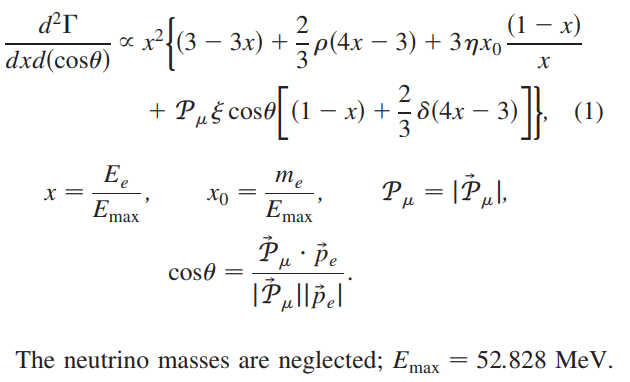image.png](attachment:00284a3e-1d7a-4a0d-9605-61039f735c5a.png)

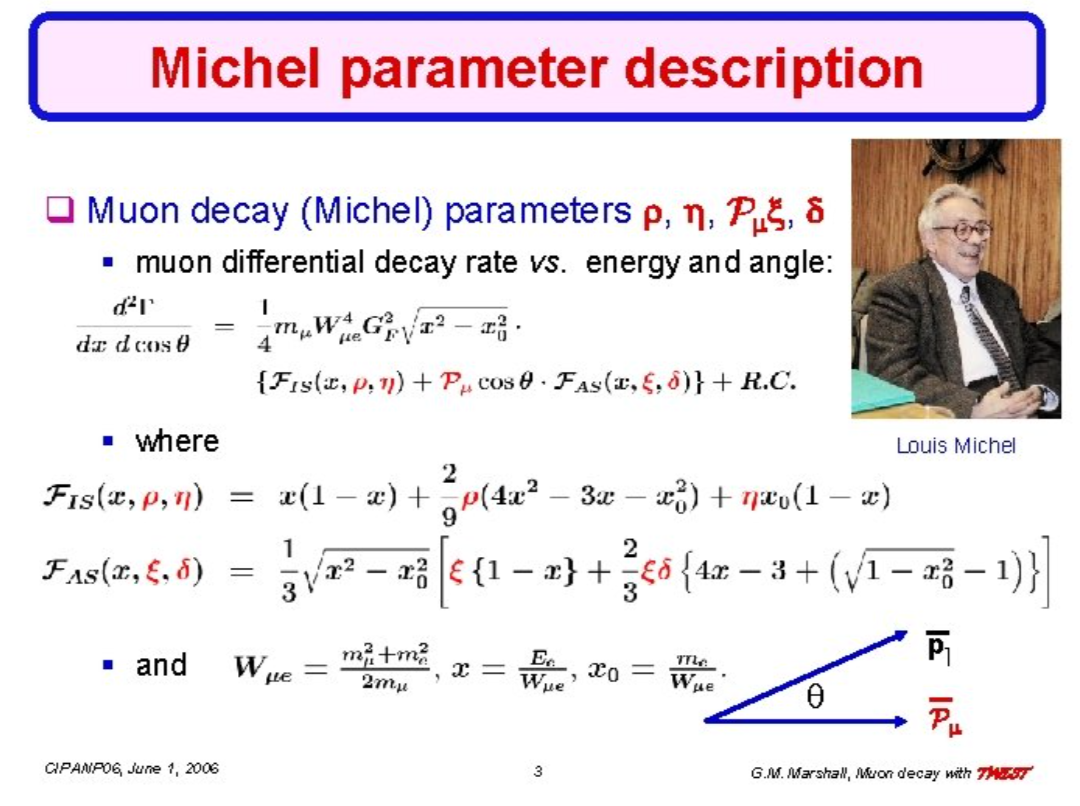
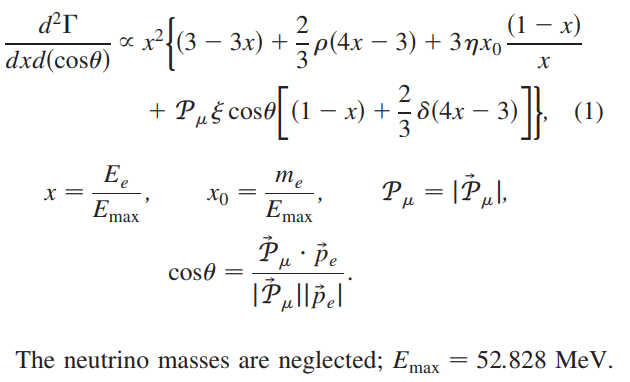

In [4]:
#   // code adapted from geant4 
#   // ***************************************************
#   //     x0 <= x <= 1.   and   -1 <= y <= 1
#   //
#   //     F(x,y) = f(x)*g(x,y);   g(x,y) = 1.+g(x)*y
#   // ***************************************************

#   // ***** sampling F(x,y) directly (brute force) *****

# sampling parameters
MAX_LOOP=100000 # the number of sample you want
Michel_Samples = np.zeros(shape=(MAX_LOOP,2)) # store samples

count =0 # keep track of the accumulated samples

while (count<MAX_LOOP):
    rndm = np.random.uniform(0,1);

    x = x0 + rndm*(1.-x0); # throw out a guess for x
    
    x_squared = x*x;

    F_IS=0; F_AS=0; G_IS=0; G_AS=0
    
    F_IS = 1./6.*(-2.*x_squared+3.*x-x0_squared);
    F_AS = 1./6.*np.sqrt(x_squared-x0_squared)*(2.*x-2.+np.sqrt(1.-x0_squared));

    G_IS = 2./9.*(michel_rho-0.75)*(4.*x_squared-3.*x-x0_squared);
    G_IS = G_IS + michel_eta*(1.-x)*x0;

    G_AS = 3.*(michel_xsi-1.)*(1.-x);
    G_AS = G_AS+2.*(michel_xsi*michel_delta-0.75)*(4.*x-4.+np.sqrt(1.-x0_squared));
    G_AS = 1./9.*np.sqrt(x_squared-x0_squared)*G_AS;

    F_IS = F_IS + G_IS;
    F_AS = F_AS + G_AS;

# / *** Radiative Corrections ***
    omega =  np.log(EMMU/EMASS);
    R_IS = F_c(x,x0,omega);

    F = 6.*F_IS + R_IS/np.sqrt(x_squared-x0_squared);

# // *** Radiative Corrections ***

    R_AS = F_theta(x,x0,omega);

    rndm = np.random.uniform(0,1);

    ctheta = 2.*rndm-1.; # throw out a guess for theta (cosine of angle between spin and momentum of positron, range from -1 to 1)

    G = 6.*F_AS - R_AS/np.sqrt(x_squared-x0_squared);
    

# combine separate parts

    FG = np.sqrt(x_squared-x0_squared)*F*(1.+(G/F)*ctheta);

    if(FG>FG_max):
        Print("G4MuonDecayChannelWithSpin::DecayIt()","PART113", "JustWarning, Problem in Muon Decay: FG > FG_max");
        FG_max = FG;

    rndm = np.random.uniform(0,1); # throw out a guess for THOR

    if (FG >= rndm*FG_max): # points ?? above ?? the surface of distribution get sampled ?????????????
        Michel_Samples[count,0] = x # store E/EMAX
        Michel_Samples[count,1] = ctheta # store cos(theta)
        count += 1


# 1.1 visualize the sampled michel spectrum and compare with theoretical calculations

taken from: IntroductoryMuonScience-Nagamine p.12

all the following equations are for decay positrion,

$${E_e}^2(3E_m-2E_e)[1-A(E_e)\cos \theta] $$

$$A(E_e) = \frac{E_m - 2E_e}{3E_m-2E_e}$$

$$\propto x^2[(3-2x)-(1-2x)\cos \theta]$$

integrated over all $\theta$ :

$$\propto x^2 ( 3-2x)$$

# 1.1.1 distribution over $x$ and $\theta$

In [5]:
# theoretical calculation
x = np.zeros(shape=(2,100))
x[0]=np.linspace(0.0,1.0,100) # exclude the endpoint to prevent integral blows up !

y = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x[1] = y(x[0])
x[1] = x[1]/np.mean(x[1]) # dividing a distribution with its mean is p.d.f

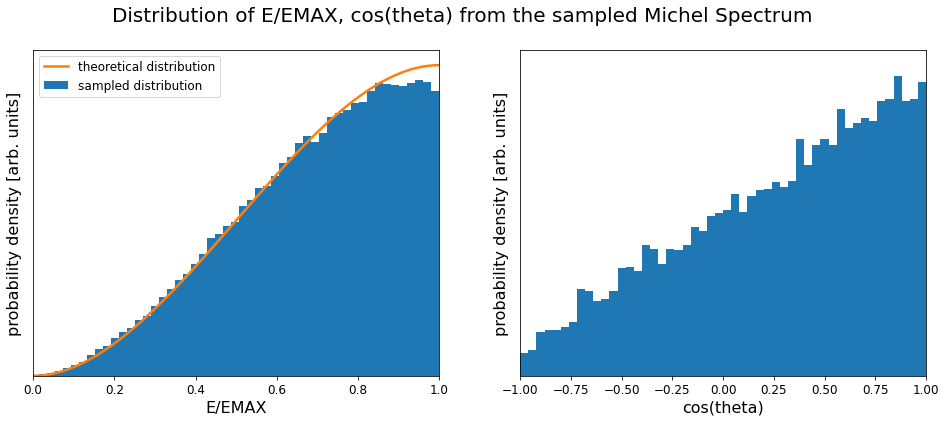

In [6]:
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(16,6))
fig.suptitle('Distribution of E/EMAX, cos(theta) from the sampled Michel Spectrum ', fontsize=20)

ax1 = fig.add_subplot(1,2,1)
ax1.hist(Michel_Samples[:,0],bins=50,density=True, stacked=True,label='sampled distribution') # density:normalized
ax1.plot(x[0],x[1],linewidth=2.5,label='theoretical distribution')
ax1.set_xlim([0,1])
ax1.set_yticklabels([])
ax1.set_xlabel('E/EMAX',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(1,2,2)
ax2.hist(Michel_Samples[:,1],bins=50,density=True)
ax2.set_xlim([-1,1])
ax2.set_ylim([0.3,0.7])
ax2.set_yticklabels([])
ax2.set_xlabel('cos(theta)',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)

## can PDF > 1 ?
https://towardsdatascience.com/pdf-is-not-a-probability-5a4b8a5d9531

probability $\neq$ probability density function ($p(x)$)

the probability of finding some random variable in the interval from $x$ to $x+dx$ is $ p(x) dx $

$\int{p(x) dx}$ over a range give the probability of finding the variable in that range (say, x = a to b)

for a discrete distribution on the interval of x [a,b], which has plotted as histogram
$$ p.d.f = p(x) = \frac{\text{i-th bin count}}{\text{(sum of count)*(bin width)}} = \frac{N_i}{\sum(N_i)*dx} $$
$$ dx = \frac{1}{b-a}$$


for a continuosly distributed y on interval [a,b]
$$p.d.f = p(x) =\frac{y}{\int_a^b{ydx}\times \frac{1}{b-a}} = \text{value of y / mean value of y}$$ 

Text(0, 0.5, 'probability density')

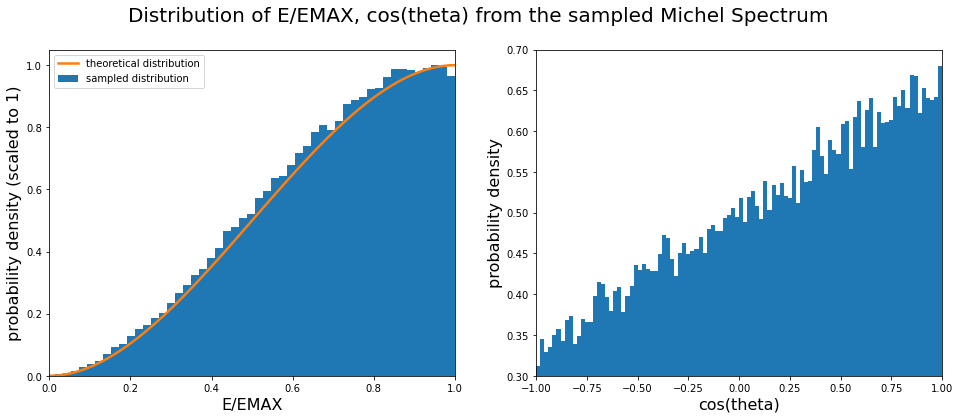

In [7]:
# theoretical distribution
x = np.zeros(shape=(2,100))
x[0]=np.linspace(0.0,1.0,100) # exclude the endpoint to prevent integral blows up !

y = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x[1] = y(x[0]) # this equation is already scaled to 1

N_bin = 50
# sample
counts, bins = np.histogram(Michel_Samples[:,0],bins=N_bin) # np.histogram return bin edges !!!
bin_width = (bins.max()-bins.min())/N_bin
counts = counts/(np.sum(counts)*bin_width) #pdf
counts = counts/(counts.max())

# draw histogram
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(16,6))
fig.suptitle('Distribution of E/EMAX, cos(theta) from the sampled Michel Spectrum ', fontsize=20)

# zz = Michel_Samples[:,0]/np.mean(Michel_Samples[:,0])
ax1 = fig.add_subplot(1,2,1)
ax1.hist(bins[:-1], bins, weights=counts,label='sampled distribution') 
ax1.plot(x[0],x[1],linewidth=2.5,label='theoretical distribution') 
ax1.set_xlim([0,1])
ax1.set_xlabel('E/EMAX',fontsize=16)
ax1.set_ylabel("probability density (scaled to 1)",fontsize=16)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.hist(Michel_Samples[:,1],bins=100,density=True)
ax2.set_xlim([-1,1])
ax2.set_ylim([0.3,0.7])
ax2.set_xlabel('cos(theta)',fontsize=16)
ax2.set_ylabel("probability density",fontsize=16)

# 1.1.2 Michel spectrum for $\theta$ = 0 , 90 ,180

In [8]:
michel_cut_ctheta1 = Michel_Samples[abs(Michel_Samples[:,1]-1)<=0.5] # ctheta= 1
michel_cut_ctheta0 = Michel_Samples[abs(Michel_Samples[:,1])<=0.5]   # ctheta= 0
michel_cut_ctheta_1 = Michel_Samples[abs(Michel_Samples[:,1]+1)<=0.5] # ctheta= -1

# compare with theoretical calculation
x = np.zeros(shape=(5,100))
x[0]=np.linspace(0.0,1.0,100) # exclude the endpoint to prevent integral blows up !

y2 = lambda x,ctheta: x*x*((3-2*x)-(1-2*x)*ctheta) # IntroductoryMuonScience-Nagamine fig1.6 full formula
x[1] = y2(x[0],1)
x[1] = x[1]/np.mean(x[1]) 

x[2] = y2(x[0],0)
x[2] = x[2]/np.mean(x[2]) 

x[3] = y2(x[0],-1)
x[3] = x[3]/np.mean(x[3]) 

y1 = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x[4] = y1(x[0])
x[4] = x[4]/np.mean(x[4]) 

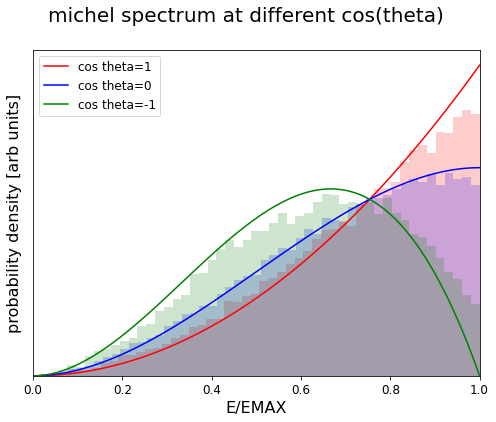

In [9]:
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(8,6))
fig.suptitle('michel spectrum at different cos(theta) ', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(michel_cut_ctheta1[:,0],bins=50,density=True, alpha=0.2,color='red')
ax1.plot(x[0],x[1],color='red',label='cos theta=1')

ax1.hist(michel_cut_ctheta0[:,0],bins=50,density=True, alpha=0.2,color='blue')
ax1.plot(x[0],x[2],color='blue',label='cos theta=0')

ax1.hist(michel_cut_ctheta_1[:,0],bins=50,density=True, alpha=0.2,color='green')
ax1.plot(x[0],x[3],color='green',label='cos theta=-1')

ax1.legend(fontsize=12)
ax1.set_xlim([0,1])
ax1.set_xlabel('E/EMAX',fontsize=16)
ax1.set_ylabel("probability density [arb units]",fontsize=16)
ax1.set_yticklabels([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)

# 2.0 sampling positron 3-momentum (in Muon rest frame)

<p style="color:red;">try the easy one: used theta (from Michel) and random phi to fix positron momentum</p>

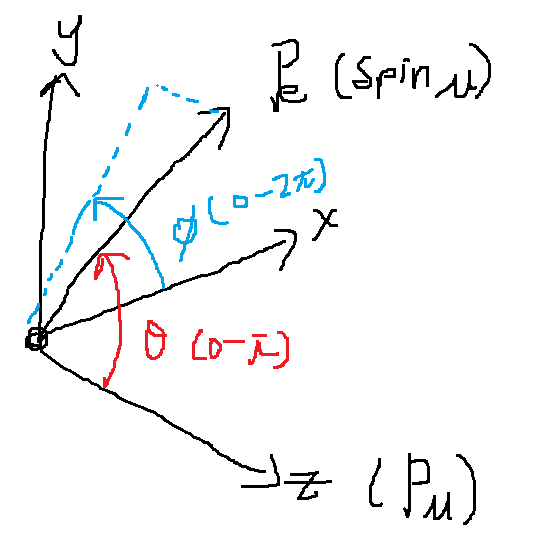

<p style="color:red;">this get you px,py,pz</p>

<p style="color:red;">boost in pz direction, and recalculate the Energy, to get 4-momenta in LAB</p>

<p style="color:red;">*** Warning, pz is in local coordinate, but can easily transformed to ring coordinates by rotating x,y plane</p>

In [10]:
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Vector/LorentzVector.h
four_momenta_mu_frame = np.zeros(shape=(MAX_LOOP,6)) # store posiInitE, posiInitPX, posiInitPY ,posiInitPZ (in MRF)

for i in range(MAX_LOOP):
    energy = Michel_Samples[i,0]*W_mue
    if(energy < EMASS):energy = EMASS;
    
    three_momentum = np.sqrt(energy*energy - EMASS*EMASS);
    
    # retrieve E,theta from Michel spectrum
    ctheta = Michel_Samples[i,1]
    stheta = np.sqrt(1.-ctheta*ctheta);
    
    rndm = np.random.uniform(0,1) # generate a random angle phi to fix muon momentum in x,y,z
    phi = twopi * rndm;
    cphi = np.cos(phi);
    sphi = np.sin(phi);
    
    # momentum of the decay positron with respect to the muon spin
    px0 = stheta*cphi*three_momentum ;
    py0 = stheta*sphi*three_momentum ;
    pz0 = ctheta*three_momentum ;
    
    # introduce aritificial spin precession
    rndm = np.random.uniform(0,1)
    alpha= twopi * rndm;
    calpha = np.cos(alpha); # muDecayPolZ i not yet understand, but polarization involve counting, so it is lorentz transformed into itself
    salpha = np.sin(alpha); # muDecayPolX ref: https://arxiv.org/pdf/hep-ph/0409166.pdf
    
    # rotate px py pz wrt 'new' spin direction
    px = calpha*px0 + salpha*pz0
    py = py0
    pz = -salpha*px0 + calpha*pz0
    
    four_momenta_mu_frame[i,0] = energy
    four_momenta_mu_frame[i,1] = px
    four_momenta_mu_frame[i,2] = py
    four_momenta_mu_frame[i,3] = pz
    four_momenta_mu_frame[i,4] = salpha # muDecayPolX
    four_momenta_mu_frame[i,5] = calpha # muDecayPolZ

# 2.1 visualize sampled posiInitPX, posiInitPY ,posiInitPZ (in MRF)

In [11]:
# load musrSim data
df = r.RDataFrame("t1",'../musr_1.root')
df = df.Define("posiInitE","sqrt(posIniMomX*posIniMomX + posIniMomY*posIniMomY + posIniMomZ*posIniMomZ - 0.511*0.511)")
musrSim_dict = df.AsNumpy()

In [12]:
print('E (min/max, toyMC vs musrSim)')
print(four_momenta_mu_frame[:,0].min(),four_momenta_mu_frame[:,0].max())
print(musrSim_dict['posiInitE'].min(),musrSim_dict['posiInitE'].max())

print('\n px')
print(four_momenta_mu_frame[:,1].min(),four_momenta_mu_frame[:,1].max())
print(musrSim_dict['posIniMomX'].min(),musrSim_dict['posIniMomX'].max())

print('\n py')
print(four_momenta_mu_frame[:,2].min(),four_momenta_mu_frame[:,2].max())
print(musrSim_dict['posIniMomY'].min(),musrSim_dict['posIniMomY'].max())

print('\n pz')
print(four_momenta_mu_frame[:,3].min(),four_momenta_mu_frame[:,3].max())
print(musrSim_dict['posIniMomZ'].min(),musrSim_dict['posIniMomZ'].max())

E (min/max, toyMC vs musrSim)
0.6947263777429946 52.80012139034329
nan nan

 px
-52.60183509616623 52.7044711675294
-52.55700371946467 52.425482936498106

 py
-52.64521798859951 52.740265035183484
-52.68777154792467 52.462417332055225

 pz
-52.473687660377685 52.56603231509718
-51.12039859407932 52.55665064725118


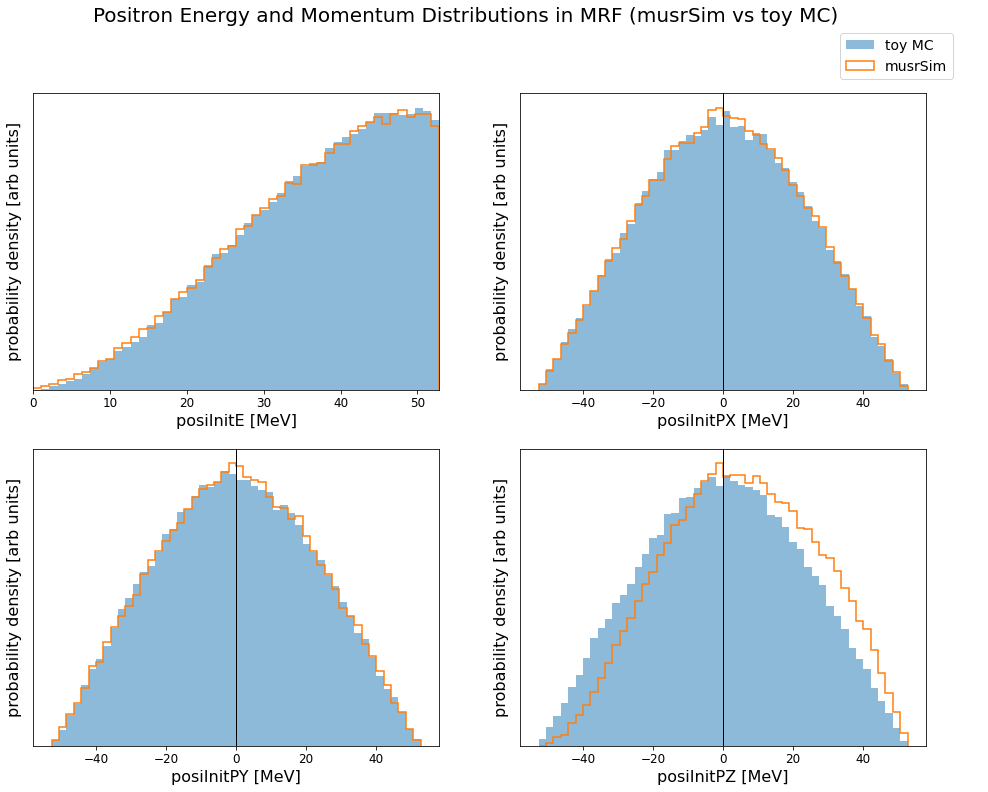

In [13]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in MRF (musrSim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_mu_frame[:,0],range=(0,52.8),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(musrSim_dict['posiInitE'],range=(0,52.8),bins=50,density=True,histtype='step',linewidth=1.5,label='musrSim')
ax1.set_xlim([0,52.8])
ax1.set_yticklabels([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb units]",fontsize=16)


ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_mu_frame[:,1],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax2.hist(musrSim_dict['posIniMomX'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb units]",fontsize=16)


ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_mu_frame[:,2],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax3.hist(musrSim_dict['posIniMomY'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_yticklabels([])
ax3.tick_params(axis='y', left=False)
ax3.tick_params(axis='x', labelsize=12)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb units]",fontsize=16)


ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_mu_frame[:,3],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax4.hist(musrSim_dict['posIniMomZ'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_yticklabels([])
ax4.tick_params(axis='y', left=False)
ax4.tick_params(axis='x', labelsize=12)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb units]",fontsize=16)


fig.legend(loc=(0.85,0.9),fontsize=14)
# plt.savefig('fig_MRF.png')

# 3.0 lorentz boost in pz direction (to LAB frame)

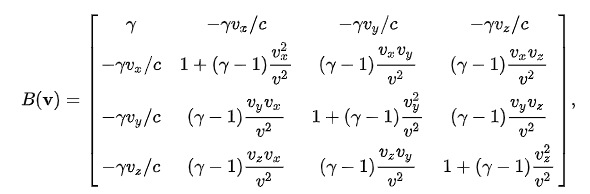

In [14]:
def Lorentz_Boost(x_0,x_1,x_2,x_3,gamma,beta1,beta2,beta3,inverse=False):
    '''
    Implementation of general lorentz boost, from jackson (11.98)
    x is a 4-vector, with components x_0, x_1, x_2, x_3 (minkowski notation with 0,1,2,3 represent ct,x,y,z)
    x can be in K or K' frame, the inverse parameter will take care the correct transformation
    beta1, beta2, beta3 are the components of the velocity of the moving frame K' (K and K' axes are taken to be all parallel to each other)
    
    '''

    if(inverse==True):    # invserse transformation from K' back to K (lab), beta changes sign
        beta1 = -beta1
        beta2 = -beta2
        beta3 = -beta3

    beta_squared = (gamma*gamma - 1) / (gamma*gamma)
        
    #calculate all matrix element of the transformation
    B_00 = gamma

    B_01 = -gamma*beta1

    B_02 = -gamma*beta2

    B_03 = -gamma*beta3


    B_10 = -gamma*beta1

    B_11 = 1+(gamma-1)*(beta1*beta1)/(beta_squared)

    B_12 = (gamma-1)*(beta1*beta2)/(beta_squared)

    B_13 = (gamma-1)*(beta1*beta3)/(beta_squared)


    B_20 = -gamma*beta2

    B_21 = (gamma-1)*(beta2*beta1)/(beta_squared)

    B_22 = 1+(gamma-1)*(beta2*beta2)/(beta_squared)

    B_23 = (gamma-1)*(beta2*beta3)/(beta_squared)


    B_30 = -gamma*beta3

    B_31 = (gamma-1)*(beta3*beta1)/(beta_squared)

    B_32 = (gamma-1)*(beta3*beta2)/(beta_squared)

    B_33 = 1+(gamma-1)*(beta3*beta3)/(beta_squared)


    # calculate the results
    x0_transformed = B_00*x_0 + B_01*x_1 + B_02*x_2 + B_03*x_3

    x1_transformed = B_10*x_0 + B_11*x_1 + B_12*x_2 + B_13*x_3

    x2_transformed = B_20*x_0 + B_21*x_1 + B_22*x_2 + B_23*x_3

    x3_transformed = B_30*x_0 + B_31*x_1 + B_32*x_2 + B_33*x_3

    return [x0_transformed, x1_transformed, x2_transformed, x3_transformed]

In [15]:
def Calculate_Phase(y1, x1, y2, x2):
   # compute the angle difference between vector1 and vector2 given their x,y components. */
   
    ans1 = np.arctan2(y1,x1);  # angle of vector 1, muDecayP
    ans2 = np.arctan2(y2,x2);  # angle of vector 2, muDecayPol
    ans = ans1 - ans2;

    if(ans<0):
        ans = ans+2*np.pi;

    return ans;

In [16]:
# lorentz boost parameter (in gm2 experiment)
p_mu_magic = 3.1 # GeV/c (PRL)
gamma_mu = 29.3 # (PRL)
beta_mu_squared = 1-(1/gamma_mu)*(1/gamma_mu) # check the redundancy !
beta_mu = np.sqrt(beta_mu_squared) # calculated from gamma_mu
gamma_tau_mu = 64.4e-6 # sec (PRD)

four_momenta_LAB = np.zeros(shape=(MAX_LOOP,10)) # store the final posiInitE, posiInitPX , posiInitPY, posiInitPZ, cos(angle of z-axis with muon momentum)
# copy the values from previos step
four_momenta_LAB[:,6] = four_momenta_mu_frame[:,4] # muDecayPolZ
four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolX  


for i in range(MAX_LOOP):
    # introduce artificial cyclotron motion for muon (using random number to test)
    rndm = np.random.uniform(0,1)
    rot = twopi * rndm;
    crot = np.cos(rot);
    srot = np.sin(rot);
    
    # calculate the velocity components of muon frame in LAB frame
    beta_mu_z = beta_mu*crot
    beta_mu_x = beta_mu*srot
    
    # get 4-momenta in MRF and boost to LAB frame
    E_primed  = four_momenta_mu_frame[i,0] # PosiInitE
    px_primed = four_momenta_mu_frame[i,1] # PosiInitPX
    py_primed = four_momenta_mu_frame[i,2] # PosiInitPY
    pz_primed = four_momenta_mu_frame[i,3] # PosiInitPZ
    
    # lorentz boost
    PosiInitE,PosiInitPX,PosiInitPY,PosiInitPZ= Lorentz_Boost(E_primed,px_primed,py_primed,pz_primed,gamma_mu,beta_mu_x,0,beta_mu_z,inverse=True) 
    four_momenta_LAB[i,0] = PosiInitE
    four_momenta_LAB[i,1] = PosiInitPX
    four_momenta_LAB[i,2] = PosiInitPY
    four_momenta_LAB[i,3] = PosiInitPZ
    
    four_momenta_LAB[i,4] = beta_mu_x # related to muDecayPX
    four_momenta_LAB[i,5] = beta_mu_z # related to muDecayPZ
    
    # calculate g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                            four_momenta_LAB[i,6], four_momenta_LAB[i,7])
    four_momenta_LAB[i,8] = phase # g2phase
    four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  

Text(0, 0.5, 'counts')

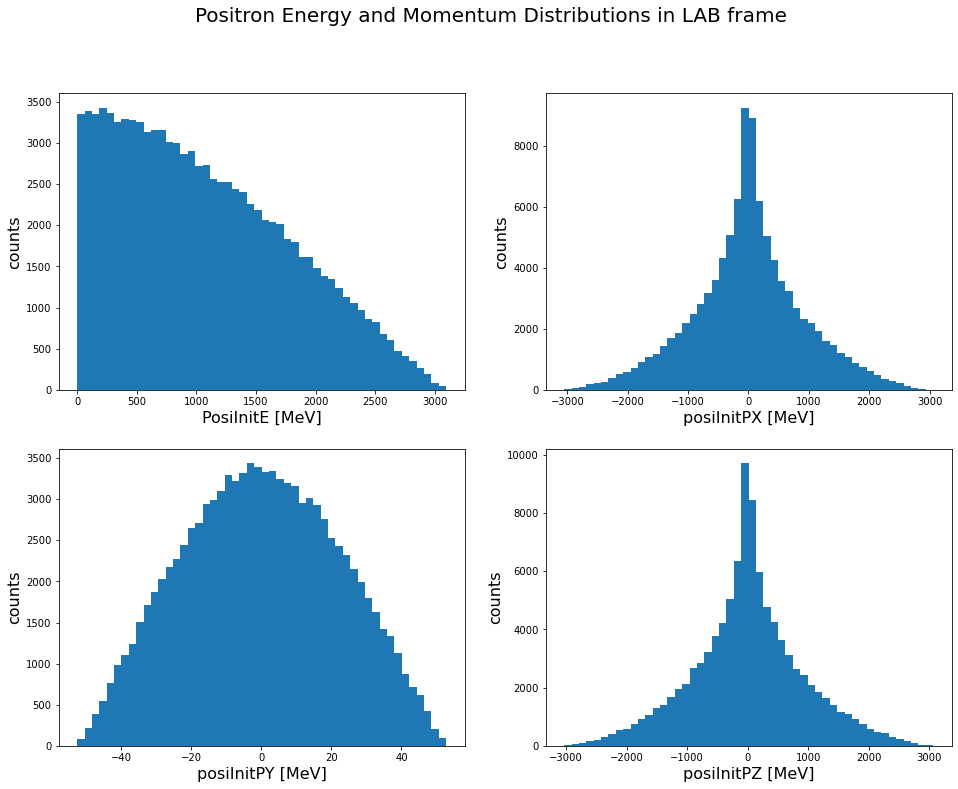

In [17]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_LAB[:,0],bins=50)
ax1.set_xlabel('PosiInitE [MeV]',fontsize=16)
ax1.set_ylabel("counts",fontsize=16)

ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_LAB[:,1],bins=50)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("counts",fontsize=16)

ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_LAB[:,2],bins=50)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("counts",fontsize=16)

ax3 = fig.add_subplot(2,2,4)
ax3.hist(four_momenta_LAB[:,3],bins=50)
ax3.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax3.set_ylabel("counts",fontsize=16)

# 4.0 Comparing with gm2ringsim data

In [18]:
r.gInterpreter.Declare("""
//#include <math.h>

double Phase(double y1, double x1, double y2, double x2) {
   /* compute the angle difference between vector1 and vector2 given their x,y components. */
   
   double ans1 = atan2(y1,x1);  //angle of vector 1, muDecayP
   double ans2 = atan2(y2,x2);  //angle of vector 2, muDecayPol
   double ans = ans1 - ans2;
   
   if(ans<0){
       ans = ans+2*M_PI;
    }
       
   return ans;
}
""")

# load gm2ringsim data
fname = "/home/junkai.ng/junkai.ng/CaloMC/gm2ringsim_muon_gasgun_ana_21378178_1.root"
df = r.RDataFrame("G2PhaseAnalyzer/g2phase",fname)
df = df.Define("g2phase", "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)") 
df = df.Define("cosg2phase", "cos(g2phase)") 
varList = ["posiInitE","posiInitPX","posiInitPY","posiInitPZ","g2phase","cosg2phase"]
data_gm2ringsim = df.AsNumpy(columns=varList)

ReadStreamerInfo, class:string, illegal uid=-2


Warning in <TClass::Init>: no dictionary for class __basic_string_common<true> is available


## 4.1 posiInitE, posiInitPX, posiInitPY, posiInitPZ

In [19]:
print('E (min/max, toyMC vs gm2ringsim)')
print(four_momenta_LAB[:,0].min(),four_momenta_LAB[:,0].max())
print(data_gm2ringsim['posiInitE'].min(),data_gm2ringsim['posiInitE'].max())

print('\n px')
print(four_momenta_LAB[:,1].min(),four_momenta_LAB[:,1].max())
print(data_gm2ringsim['posiInitPX'].min(),data_gm2ringsim['posiInitPX'].max())

print('\n py')
print(four_momenta_LAB[:,2].min(),four_momenta_LAB[:,2].max())
print(data_gm2ringsim['posiInitPY'].min(),data_gm2ringsim['posiInitPY'].max())

print('\n pz')
print(four_momenta_LAB[:,3].min(),four_momenta_LAB[:,3].max())
print(data_gm2ringsim['posiInitPZ'].min(),data_gm2ringsim['posiInitPZ'].max())

E (min/max, toyMC vs gm2ringsim)
0.5362679109241487 3091.9729391250276
0.5196881294250488 3101.15478515625

 px
-3053.1601981410954 3058.3742778978562
-3098.392578125 3084.43798828125

 py
-52.64521798859951 52.740265035183484
-56.006404876708984 55.80052185058594

 pz
-3033.2137011830214 3059.868678507687
-3089.575439453125 3087.844970703125


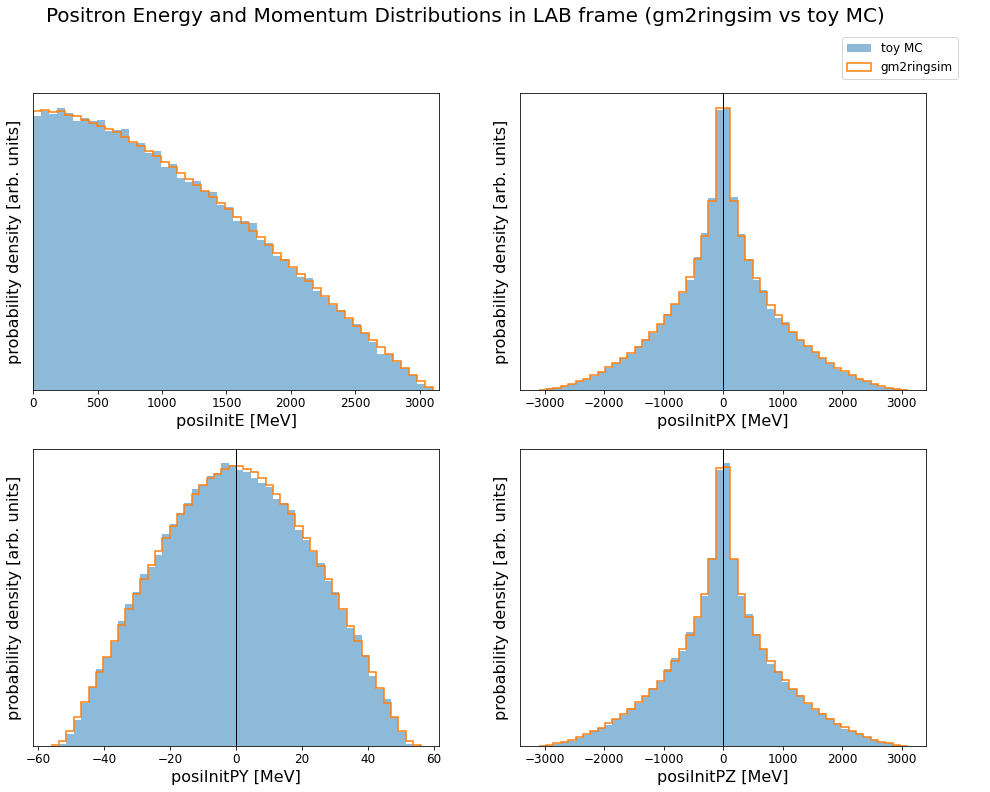

In [20]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(data_gm2ringsim['posiInitE'],range=(0,3100),density=True,bins=50,histtype='step',linewidth=1.5,label='gm2ringsim')
ax1.set_xlim([0,3150])
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_LAB[:,1],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax2.hist(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', left=False)
ax2.set_yticklabels([])

ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_LAB[:,2],range=(-56,56),bins=50,density=True,alpha=0.5)
ax3.hist(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb. units]",fontsize=16)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', left=False)
ax3.set_yticklabels([])

ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax4.hist(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb. units]",fontsize=16)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', left=False)
ax4.set_yticklabels([])


fig.legend(loc=(0.85,0.9),fontsize=12)
# plt.savefig('fig_LAB.png')

## 4.2 posiInitE distribution at different g2 phases

In [21]:
# sort out data at different cos(g2phase), for sampled data
filter1 = np.where(abs(four_momenta_LAB[:,9]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(four_momenta_LAB[:,9])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(four_momenta_LAB[:,9]+1)<=0.4 ) # ctheta= -1

four_momenta_lab_filter_1 = four_momenta_LAB[filter1]
four_momenta_lab_filter_2 = four_momenta_LAB[filter2]
four_momenta_lab_filter_3 = four_momenta_LAB[filter3]

In [22]:
# sort out data at different cos(g2phase), for gm2ringsim data
data_gm2ringsim_partial = np.zeros(shape=(2,data_gm2ringsim["posiInitE"].size))
data_gm2ringsim_partial[0] = data_gm2ringsim["posiInitE"]
data_gm2ringsim_partial[1] = data_gm2ringsim["cosg2phase"]
data_gm2ringsim_partial = data_gm2ringsim_partial.T

filter1 = np.where(abs(data_gm2ringsim_partial[:,1]-1)<=0.4 ) # ctheta= 1
filter2 = np.where(abs(data_gm2ringsim_partial[:,1])<=0.4 )   # ctheta= 0
filter3 = np.where(abs(data_gm2ringsim_partial[:,1]+1)<=0.4 ) # ctheta= -1

data_gm2ringsim_partial_filter_1 = data_gm2ringsim_partial[filter1]
data_gm2ringsim_partial_filter_2 = data_gm2ringsim_partial[filter2]
data_gm2ringsim_partial_filter_3 = data_gm2ringsim_partial[filter3]

In [23]:
print('cos=1 (min/max, toyMC vs gm2ringsim)')
print(four_momenta_lab_filter_1[:,0].min(),four_momenta_lab_filter_1[:,0].max())
print(data_gm2ringsim_partial_filter_1[:,0].min(),data_gm2ringsim_partial_filter_1[:,0].max())

print('\n cos=0')
print(four_momenta_lab_filter_2[:,0].min(),four_momenta_lab_filter_2[:,0].max())
print(data_gm2ringsim_partial_filter_2[:,0].min(),data_gm2ringsim_partial_filter_2[:,0].max())

print('\n cos=-1')
print(four_momenta_lab_filter_3[:,0].min(),four_momenta_lab_filter_3[:,0].max())
print(data_gm2ringsim_partial_filter_3[:,0].min(),data_gm2ringsim_partial_filter_3[:,0].max())

cos=1 (min/max, toyMC vs gm2ringsim)
0.6154236266645228 3091.9729391250276
0.537371814250946 3101.15478515625

 cos=0
0.5362679109241487 3078.1210106854137
0.5196881294250488 3096.66650390625

 cos=-1
0.5836711801868972 3060.797747826243
0.5411139726638794 3090.006103515625


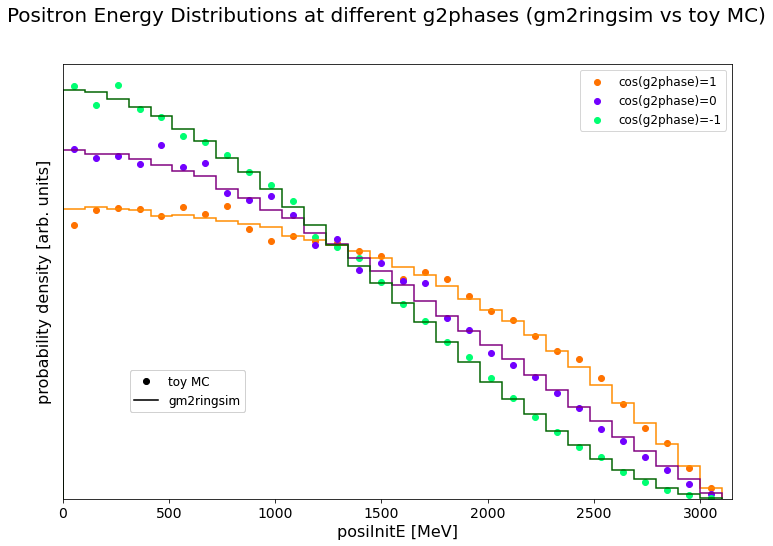

In [24]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positron Energy Distributions at different g2phases (gm2ringsim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(data_gm2ringsim_partial_filter_1[:,0],range=(-3100,3100),bins=60,density=True,color='darkorange',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_1[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#FF7200',label='cos(g2phase)=1')

ax1.hist(data_gm2ringsim_partial_filter_2[:,0],range=(-3100,3100),bins=60,density=True,color='purple',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_2[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#7200FF',label='cos(g2phase)=0')

ax1.hist(data_gm2ringsim_partial_filter_3[:,0],range=(-3100,3100),bins=60,density=True,color='darkgreen',histtype='step',linewidth=1.5)
bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_3[:,0],range=(-3100,3100),bins=60,density=True)
bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
ax1.scatter(bin_midpt,bin_counts,c='#00FF72',label='cos(g2phase)=-1')


ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

lgd1 = ax1.legend(fontsize=12)
ax1.add_artist(lgd1)

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [],linewidth=0, color='black', marker='o', markersize=6, label='toy MC')
line2 = mlines.Line2D([], [],linewidth=1.5, color='black', markersize=8, label='gm2ringsim')
lgd2 = ax1.legend(handles=[line1,line2],fontsize=12,loc=(0.1,0.2))
ax1.add_artist(lgd2)

# plt.savefig('fig_g2phase.png')

## 4.3 Energy vs g2phase Distribution

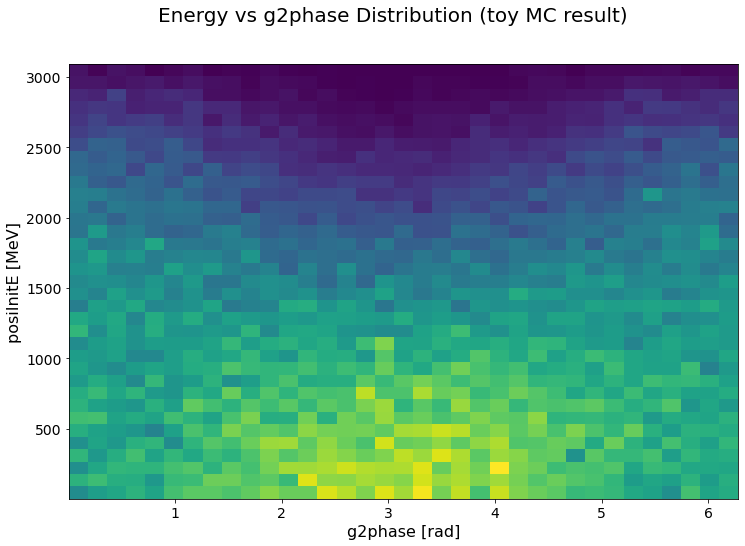

In [25]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (toy MC result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(four_momenta_LAB[:,8],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# fig.show()
# plt.savefig('fig_E_v_g2phase.png')

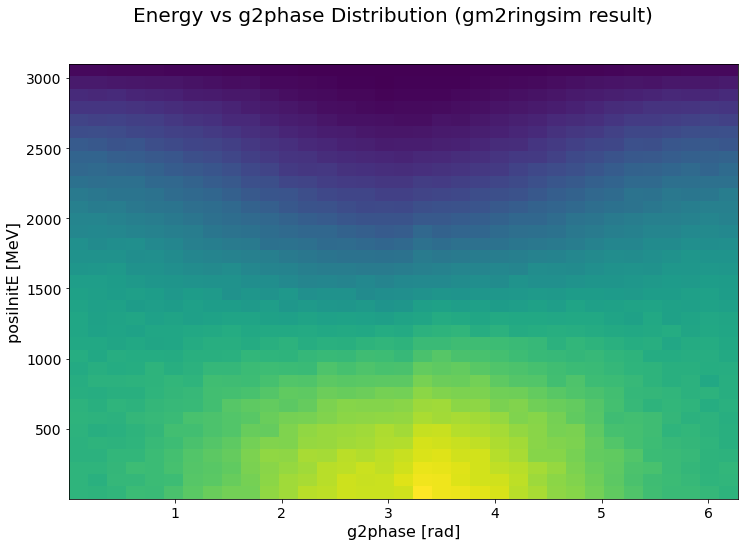

In [26]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Energy vs g2phase Distribution (gm2ringsim result)', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(data_gm2ringsim['g2phase'],data_gm2ringsim['posiInitE'],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('g2phase [rad]',fontsize=16)
ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# fig.show()
# plt.savefig('fig_E_v_g2phase2.png')

# PosiInitE distribution: MRF vs LAB

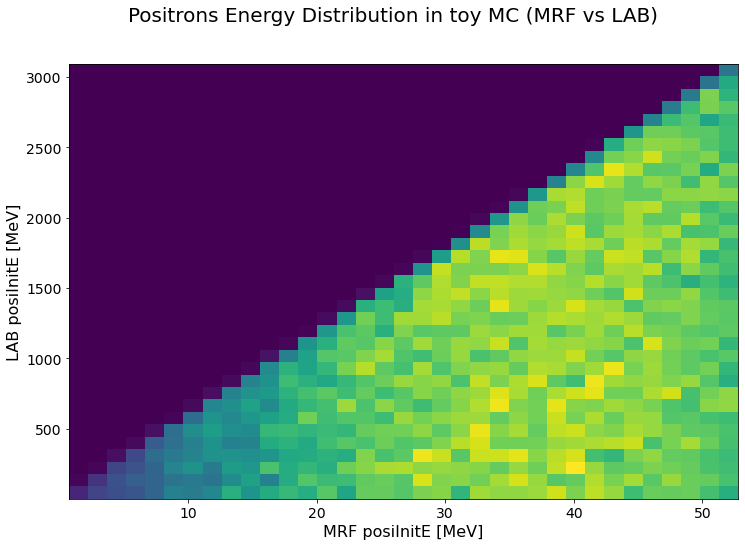

In [27]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution (MRF vs LAB) in toyMC', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist2d(four_momenta_mu_frame[:,0],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

ax1.set_xlabel('MRF posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("LAB posiInitE [MeV]",fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# fig.show()
# plt.savefig('fig_E_v_g2phase.png')

In [28]:
# sort out data at different MRF energy cut
filter4 = np.where(four_momenta_mu_frame[:,0]>=1 )
filter5 = np.where(four_momenta_mu_frame[:,0]>=5 )
filter6 = np.where(four_momenta_mu_frame[:,0]>=10 )


four_momenta_lab_filter_4 = four_momenta_LAB[filter4]
four_momenta_lab_filter_5 = four_momenta_LAB[filter5]
four_momenta_lab_filter_6 = four_momenta_LAB[filter6]

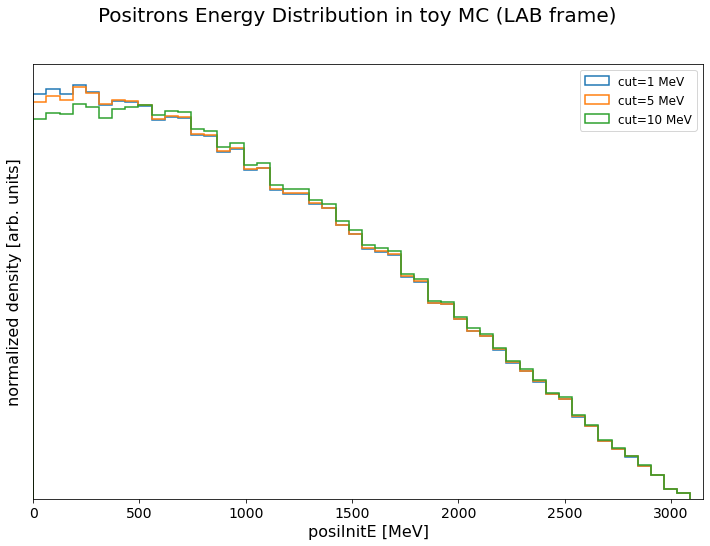

In [29]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Positrons Energy Distribution (LAB frame) in toy MC ', fontsize=20)

ax1 = fig.add_subplot(1,1,1)
ax1.hist(four_momenta_lab_filter_4[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=1 MeV')
ax1.hist(four_momenta_lab_filter_5[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=5 MeV')
ax1.hist(four_momenta_lab_filter_6[:,0],bins=50,density=True,histtype='step',linewidth=1.5,label='cut=10 MeV')

ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("normalized density [arb. units]",fontsize=16)
ax1.set_xlim([0,3150])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])
ax1.legend(fontsize=12)

# plt.savefig('fig_E_v_g2phase.png')